##網路安全的資料科學--專案 Project

系級: 資管三乙

姓名: 陳彥融

學號: 110306018

專案標題: Spam mail 偵測小助手


####讀取資料

In [ ]:
# 讀取資料
import pandas as pd
raw_data = pd.read_csv("https://bit.ly/4bZlFBe")

####資料前處理

In [ ]:
# 資料清理
raw_data = raw_data.dropna()

# 合併主旨與內容欄位
raw_data["text"] = raw_data["subject"] + " " + raw_data["message"]
raw_data = raw_data[["text", "label"]]

In [ ]:
# 轉小寫與清除標點符號(非單字與非空白的字符)
import re

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace("_", "")
    return text

data = raw_data.copy()
data["text"] = raw_data["text"].apply(preprocess)

####計算 class weight

In [ ]:
# 因為兩類別資料量沒有很平均，所以需計算 class weight
import numpy as np

neg, pos = np.bincount(data["label"])
total = neg + pos
print(f"Negative samples: {neg}")  # 正常郵件
print(f"Positive samples: {pos}")  # 垃圾郵件
print(f"Total samples: {total}")

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

Negative samples: 2363
Positive samples: 468
Total samples: 2831


####載入模型分詞器

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

####將資料轉為 dataset

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(data)
dataset = dataset.remove_columns("__index_level_0__")
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 2831
})

####tokenization

In [ ]:
def tokenize(data):
    result = tokenizer(data["text"], truncation = True)
    return result

In [ ]:
# tokenize
tokenized_dataset = dataset.map(tokenize, batched = True)
tokenized_dataset

Map:   0%|          | 0/2831 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2831
})

####切分資料

In [ ]:
# 將資料集切為訓練、驗證和測試三個資料集
from datasets import DatasetDict

train_val_test = tokenized_dataset.train_test_split(test_size = 0.1, seed = 100)
train_val = train_val_test["train"].train_test_split(test_size = 0.2, seed = 100)

final_dataset = DatasetDict({"train": train_val["train"], "test": train_val_test["test"], "validation": train_val["test"]})
final_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2037
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 284
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 510
    })
})

####模型相關參數設定

In [ ]:
# 設置DataCollator
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = "tf")

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

# label 和 id 的映射關係
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

batch_size = 32
num_epochs = 15

# optimizer
batches_per_epoch = len(final_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr = 2e-5, num_warmup_steps = 0, num_train_steps = total_train_steps)

# early-stopping callback
earlystop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.001, patience = 3)
callback = [earlystop]

####載入模型與製作資料集

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2, id2label = id2label, label2id = label2id)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
# 製作資料集
tf_train_set = model.prepare_tf_dataset(
    final_dataset["train"],
    shuffle = True,
    batch_size = batch_size,
    collate_fn = data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    final_dataset["test"],
    shuffle = False,
    batch_size = batch_size,
    collate_fn = data_collator,
)

tf_val_set = model.prepare_tf_dataset(
    final_dataset["validation"],
    shuffle = False,
    batch_size = batch_size,
    collate_fn = data_collator,
)

####開始 fine-tune 模型

In [ ]:
# compile
model.compile(optimizer = optimizer, metrics = ["accuracy"])

# fine-tune
training_proccess = model.fit(x = tf_train_set, validation_data = tf_val_set, epochs = num_epochs, callbacks = callback, class_weight = class_weight)

Epoch 1/15
63/63 [==============================] - 105s 1s/step - loss: 0.2977 - accuracy: 0.9142 - val_loss: 0.0609 - val_accuracy: 0.9843
Epoch 2/15
63/63 [==============================] - 74s 1s/step - loss: 0.0302 - accuracy: 0.9896 - val_loss: 0.0496 - val_accuracy: 0.9863
Epoch 3/15
63/63 [==============================] - 74s 1s/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.0401 - val_accuracy: 0.9882
Epoch 4/15
63/63 [==============================] - 74s 1s/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0371 - val_accuracy: 0.9902
Epoch 5/15
63/63 [==============================] - 74s 1s/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0356 - val_accuracy: 0.9902
Epoch 6/15
63/63 [==============================] - 74s 1s/step - loss: 7.8498e-04 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9902
Epoch 7/15
63/63 [==============================] - 74s 1s/step - loss: 5.8442e-04 - accuracy: 1.0000 - val_loss: 0.0375 - val_accuracy: 0.9902
Epoch 8/15


####畫出訓練過程的準確率圖與損失圖

In [ ]:
import matplotlib.pyplot as plt

def plot_process(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

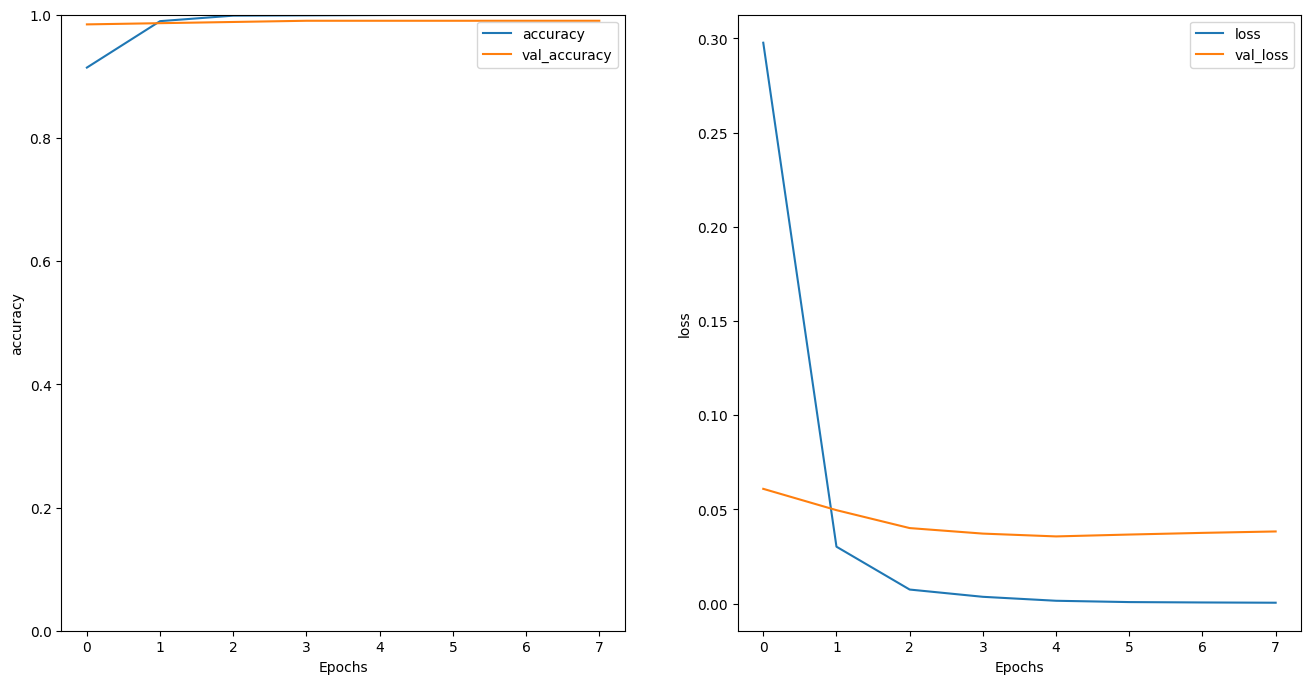

In [ ]:
# 畫出準確率圖與損失圖
plt.figure(figsize = (16, 8))

plt.subplot(1, 2, 1)
plot_process(training_proccess, "accuracy")
plt.ylim(0.0, 1.0)

plt.subplot(1, 2, 2)
plot_process(training_proccess, "loss")

####用測試資料集測試模型的準確率與損失

In [ ]:
# 測試模型性能
test_loss, test_acc = model.evaluate(tf_test_set)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

9/9 [==============================] - 3s 341ms/step - loss: 0.0236 - accuracy: 0.9894
Test Accuracy: 0.9894366264343262
Test Loss: 0.023632654920220375


In [ ]:
# 使用未 fine-tune 過的預訓練模型來測試，查看 fine-tune 的成效
model_org = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2, id2label = id2label, label2id = label2id)
model.compile(optimizer = optimizer, metrics = ["accuracy"])

test_loss, test_acc = model.evaluate(tf_test_set)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


9/9 [==============================] - 17s 611ms/step - loss: 1.5733 - accuracy: 0.6162
Test Accuracy: 0.6161971688270569
Test Loss: 1.5733267068862915


####畫出混淆矩陣看分類結果

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(labels, predictions, threshold = 0.5, data_type = "test"):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize = (6, 5))
    sns.heatmap(cm, annot = True, fmt = "d")
    plt.title("Confusion matrix on {} data".format(data_type))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

16/16 [==============================] - 6s 343ms/step


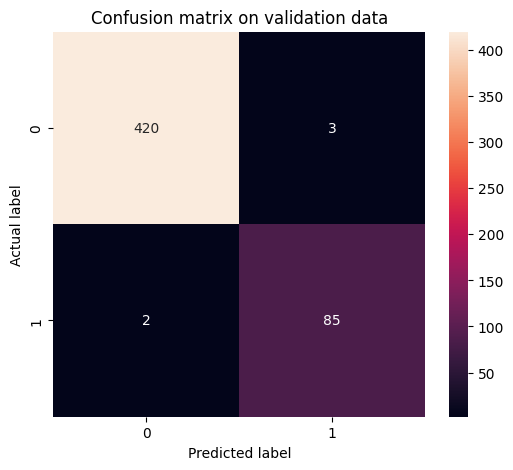

In [ ]:
# 驗證資料集的混淆矩陣
labels = np.array(final_dataset["validation"]["label"])
raw_pred = model.predict(tf_val_set, batch_size = batch_size)
predictions = np.argmax(raw_pred.logits, axis = 1)

plot_cm(labels, predictions, data_type = "validation")

9/9 [==============================] - 3s 338ms/step


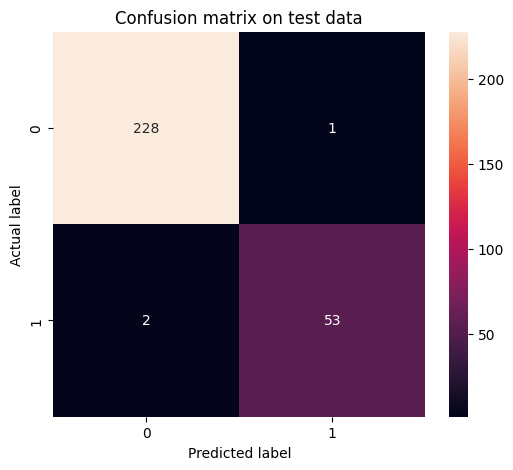

In [ ]:
# 測試資料集的混淆矩陣
labels = np.array(final_dataset["test"]["label"])
raw_pred = model.predict(tf_test_set, batch_size = batch_size)
predictions = np.argmax(raw_pred.logits, axis = 1)

plot_cm(labels, predictions)

In [ ]:
# 儲存
save_directory = "finetuned_model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('finetuned_model/tokenizer_config.json',
 'finetuned_model/special_tokens_map.json',
 'finetuned_model/vocab.txt',
 'finetuned_model/added_tokens.json',
 'finetuned_model/tokenizer.json')

####模型使用

In [ ]:
# 使用 pipeline 搭配 fine-tune 過的模型來分類測試資料集內的資料，以前五筆資料為例
from transformers import pipeline

classifier = pipeline("text-classification", model = "finetuned_model")

print("\n")
for i in range(5):
    print(f"第{i + 1}筆測試資料:")

    text = final_dataset["test"]["text"][i]
    result = classifier(text)
    label = final_dataset["test"]["label"][i]

    print(f"郵件文字: {text}", end = "")
    print(f"模型分類結果: {result}")
    print(f"實際類別: {id2label[label]}", "\n")

Some layers from the model checkpoint at finetuned_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_99']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at finetuned_model and are newly initialized: ['dropout_279']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




第1筆測試資料:


Token indices sequence length is longer than the specified maximum sequence length for this model (3359 > 512). Running this sequence through the model will result in indexing errors


郵件文字: morphophonemics  slavic languages marta harasowska morphophonemic variability  productivity  and change the case of rusyn 1998  23 x 15  5 cm  xv  266 pages cloth dm 198    approx  us  124  00 isbn 311  015761  6 trends in linguistics  studies and monographs 110 mouton de gruyter  berlin  new york this volume presents an indepth investigation of processes influencing morphophonemic variability  productivity  and change  the author adopts the labovian approach to the study of language and examines both linguistic and extralinguistic factors which bear on language use  bybee s analogybased model of morphology provides the  psychologically real  theoretical framework for representing the linguistic processes under scrutiny  the language chosen for the study is rusyn  a slavic minority language in serbia s autonomous province of vojvodina  sharing historical roots with polish  slovak  and ukrainian  presentday rusyn functions within a language contact area dominated by serbo  croatia

In [ ]:
# 以常見的 spam mail 內容來測試模型的分類能力，應該要分類為 Positive
text = "Hello, your new billing statement for April is now available online. To view your statement and make a payment, please follow the link below: [link]. To avoid an extra fee, please pay by June 1. Thank you!"
classifier("text")

[{'label': 'POSITIVE', 'score': 0.9930926561355591}]